<a href="https://colab.research.google.com/github/Not-Pace/Genre-Classifier/blob/main/MelGraphsConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Genre Classification using Mel-Graphs from Songs**

The basis of this approach was to pick up Mel-Graphs and store their details in a JSON file, which would then be used to train the NN. The NN is built from scratch, and while simple, the model does seem to do the job for the purpose.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
train_path = '/content/gdrive/My Drive/Genre-Classifier/Data/train'
test_path = '/content/gdrive/My Drive/Genre-Classifier/Data/test'

In [ ]:
MUSIC = '/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[5])

In [ ]:
DATASET_PATH = '/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:
            # load audio file

                file_path = os.path.join(dirpath, f)

                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
            
            
                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00078.wav, segment:3
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00078.wav, segment:4
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00078.wav, segment:5
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00078.wav, segment:6
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00076.wav, segment:1
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00076.wav, segment:2
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00076.wav, segment:3
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00076.wav, segment:4
/content/gdrive/My Drive/Genre-Classifier/Data/genres_original/country/country.00076.wav, segment:5
/content/gdrive/My Drive/Genre-Classifier/Data/ge

In [ ]:
DATA_PATH = "./data_10.json"
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    print('\n')
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(9, activation='softmax'))

    return model


def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 1, 32)         4

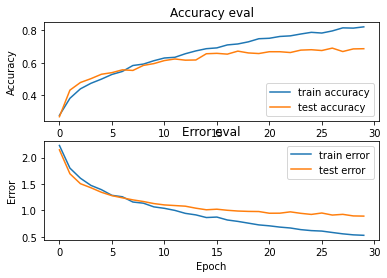

43/43 [==============================] - 0s 2ms/step - loss: 0.8831 - accuracy: 0.6793

Test accuracy: 0.6792592406272888


In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', test_acc)

#Results

This approach took us further than we had initially expected. The basic goal was to make a CNN from scratch, however, instead of picking up the image data from the dataset directly, we converted all the music files to mel-spectrograms, and saved all their data in a JSON file, which we then used to train the data. Unlike the Transfer Learning based NN, this one was way more consistent when it come to validation accuracy, only dropping off a little at around the 20th epoch. The losses reduced at an equal rate. The final accuracy of this model was 67.9%, somewhat close to most results we'd seen on this dataset so far. 